In [12]:
from src.papers.io import db
from dotenv import load_dotenv
import os

load_dotenv()
# TODO variables de entorno y no usar caminos relativos
EXTENDED_CRAWLER_DATA_PATH = os.getenv("EXTENDED_CRAWLER_DATA_PATH")
MILVUS_DB = os.getenv("MILVUS_DB")
MILVUS_COLLECTION = os.getenv("MILVUS_COLLECTION")
MILVUS_ALIAS = os.getenv("MILVUS_ALIAS")
MILVUS_HOST = os.getenv("MILVUS_HOST")
MILVUS_PORT = os.getenv("MILVUS_PORT")

milvus_client = db.Milvus(
    # db=MILVUS_DB, 
    collection=MILVUS_COLLECTION, 
    alias=MILVUS_ALIAS,
    host=MILVUS_HOST,
    port=MILVUS_PORT, 
    new_collection=False
)   



In [ ]:
query="Spot instances"

In [ ]:
nn_papers = milvus_client.search(
    text=query,
    output_fields=[
        "Title",
        "TLDR",
        "Abstract",
        "KeyConcepts",
        "Year",
        "Conference",
        "Summary",
        "AuthorsAndInstitutions"
    ],
    limit=100,
    hybrid=True,
    hybrid_fields=[
        "AbstractVector", 
        "TitleVector", 
        "TLDRVector",
        "KeyConceptsVector"
    ],
    expr="Year in ['2023']"
)

In [ ]:
papers = [paper["entity"] for paper in nn_papers]
for paper in papers:
    print(paper["Year"])

In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama


In [ ]:
template = """Question: {question}

Answer: Let's think step by step."""

prompt = ChatPromptTemplate.from_template(template)

model = ChatOllama(model="llama3.2")

chain = prompt | model

chain.invoke({"question": "What is LangChain?"})

In [ ]:
from langchain_core.messages import HumanMessage

response = model.invoke([HumanMessage(content="hi!")])
response

In [ ]:
tools = []
model_with_tools = model.bind_tools(tools)

response = model_with_tools.invoke([HumanMessage(content="Hi!")])

print(f"ContentString: {response.content}")
print(f"ToolCalls: {response.tool_calls}")

response = model_with_tools.invoke([HumanMessage(content="What's the weather in SF?")])

print(f"ContentString: {response.content}")
print(f"ToolCalls: {response.tool_calls}")

### Agente básico
Las funciones a utilizar son proporcionada por medio de tools. Estas toman un input a partir de la query y son devueltos

Se debe tipifizar la salida con pydantic, que es proporcionada al agente

In [113]:

# Base agent
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel
from langchain_ollama import ChatOllama

model = ChatOllama(model="qwen3")

def get_person(person: str) -> str:  
    """Get person information."""
    return f"Jaimito is my cousin, lives in Madrid, he is 7 years old"

class WhoIsResponse(BaseModel):
    person: str
    lives_in: str
    age: int
    
tools = [get_person]
agent = create_react_agent(
    model=model,
    tools=tools,
    response_format=WhoIsResponse,
    prompt="You are a helpful assistant that uses only the feedback you are provided",  
)
response = agent.invoke(
    {"messages": [{"role": "user", "content": "Who is Jaimito?"}]}
)

response["structured_response"]



WhoIsResponse(person='Jaimito', lives_in='Madrid', age=7)

### Minimal workflow

In [ ]:
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pydantic import BaseModel
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_ollama import ChatOllama

model = ChatOllama(model="llama3.1:8b")

def get_weather(city: str) -> str:
    """Get weather for a given city."""
    print("weather")
    return f"It's always sunny in {city}!"

def who_is(text: str) -> str:  
    """who is person information."""
    print("person")
    return "Jaimito is my cousin, lives in Madrid, he is 7 years old"

# class DescriptionResponse(BaseModel):
#     person: str
#     lives_in: str
#     age: int

# agent = create_react_agent(
#     model=model,
#     tools=[get_weather],
#     prompt="You are a helpful assistant"
# )

tools = []

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

# Tell the LLM which tools it can call
llm_with_tools = model.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [model.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Add tool node
# tool_node = ToolNode(tools)
# graph_builder.add_node("tools", tool_node)

# Add condition to call a node or another
# graph_builder.add_conditional_edges(
#     "chatbot",
#     tools_condition,
# )

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
# graph_builder.add_edge("tools", "chatbot")
graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


In [ ]:
stream_graph_updates("Spot instances papers")

### Prototipo de agente

In [7]:

# Base agent
from langgraph.prebuilt import create_react_agent
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage

query = "Which papers were published in 2022 in nsdi related to serverless cloud computing? Select only those from Germany. Omit also citations from 2023"
model = ChatOllama(model="qwen3", temperature=0, top_k=20, top_p=0.8)

class FilterOptions(BaseModel):
    """
    Class for filter option. 
    - value corresponds for to the value to be used in filtering
    - equal indicates if the condition indicates equality
    - citation indicates if this condition is referred only to cited papers
    """
    value: str
    equal: bool
    citation: bool

class FilterParameters(BaseModel):
    main_concept: str = None
    authors: list[FilterOptions] = None
    institutions: list[FilterOptions] = None
    countries: list[FilterOptions] = None
    years: list[FilterOptions] = None
    conferences: list[FilterOptions] = None
    
def get_query_filter_conditions(query: str, model: ChatOllama) -> FilterParameters:
    
    messages = [
        SystemMessage("""
        You are a helpful assistant that uses only the input the user provides. Your role is to help research paper data related to the topics the user asks about.
        Fields with list of FilterOptions type must be filled as follows:
        - value: The value of the field to be filled
        - equal: False if it is asked to be different from the value
        - citation: If the field value refers to paper citations
        Return JSON with (if not mentioned, leave it as None):
        - main_concept (string). Topic of research
        - years (list[FilterOptions]). Publish years
        - authors (list[FilterOptions]). List of paper authors
        - institutions (list[FilterOptions]). All must be valid institutions laike universities or corporations.
        - countries (list[FilterOptions]). All must be valid countries. Translate them to usual abbreviaions like US for United Staes of America or DE for Germany
        - conferences (list[FilterOptions]). List of valid conferences: IEEECloud, Middleware, SIGCOMM, eurosys
        Example response for 2024 papers about spot instances with 100+ citations published in middleware. Authors must be from Harvard University. Cited papers must not be from Canada:
        {{
            "main_concept": "spot instances",
            "authors": None,
            "institutions": [{{ "value": "Harvard University", "equal": True, "citation": False}}],
            "countries": [{{"value": "CA", "equal": False, "citation": True}}],
            "years": [{{"value": "2025", "equal": True, "citation": False}}],
            "conferences": [{{"value": "Middleware", "equal": True, "citation": False}}],
        }}
        /no_think
        """),
        HumanMessage(query),
    ]
    # response = model.with_structured_output(FilterParameters).invoke(messages)
    response = model.invoke(messages)
    print(response)
    # return response
    messages_for_structure = [
        messages[0],
        HumanMessage(f""" 
        Return JSON with (if not mentioned, leave it as None):
        - value: The value of the field to be filled
        - equal: False if it is asked to be different from the value
        - citation: If the field value refers to paper citations
        Return JSON with (if not mentioned, leave it as None):
        - main_concept (string). Topic of research
        - years (list[FilterOptions]). Publish years
        - authors (list[FilterOptions]). List of paper authors
        - institutions (list[FilterOptions]). All must be valid institutions laike universities or corporations.
        - countries (list[FilterOptions]). All must be valid countries. Translate them to usual abbreviaions like US for United Staes of America or DE for Germany
        - conferences (list[FilterOptions]). List of valid conferences: IEEECloud, Middleware, SIGCOMM, eurosys
        Using these previous result:
        {response}
        /no_think
        """
        )
    ]
    structured_response = model.with_structured_output(FilterParameters).invoke(messages_for_structure)
    print(structured_response)
    
    return structured_response

filter_conditions = get_query_filter_conditions(query, model)

content='<think>\n\n</think>\n\n{\n    "main_concept": "serverless cloud computing",\n    "years": [\n        {\n            "value": "2022",\n            "equal": True,\n            "citation": False\n        },\n        {\n            "value": "2023",\n            "equal": False,\n            "citation": True\n        }\n    ],\n    "countries": [\n        {\n            "value": "DE",\n            "equal": True,\n            "citation": False\n        }\n    ],\n    "conferences": [\n        {\n            "value": "NSDI",\n            "equal": True,\n            "citation": False\n        }\n    ]\n}' additional_kwargs={} response_metadata={'model': 'qwen3', 'created_at': '2025-05-28T20:01:22.558509177Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2501749320, 'load_duration': 12906874, 'prompt_eval_count': 431, 'prompt_eval_duration': 37570963, 'eval_count': 140, 'eval_duration': 2447817977, 'model_name': 'qwen3'} id='run-9df388ee-d64e-4855-9c14-295ea86e0070-0' usage_me

In [8]:
def build_expr_for_filter_field(filter_options: list[FilterOptions], field_name: str, json_field: bool = False) -> str:
    expr = ""
    in_expr = []
    not_in_expr = []

    if not filter_options:
        return ""
    
    for filter_option in filter_options:
        if not filter_option.citation:
            if filter_option.equal:
                in_expr.append(filter_option.value)
            else:
                not_in_expr.append(filter_option.value)
            
    if len(in_expr) > 0:
        if len(expr) == 0:
            if json_field:
                expr = f"json_contains_any({field_name}, {in_expr})"
            else:
                expr = f"{field_name} in {in_expr}"
        else:
            if len(expr) == 0:
                if json_field:            
                    expr += f"and json_contains_any({field_name}, {in_expr})"
                else:
                    expr += f"and {field_name} in {in_expr}"

    if len(not_in_expr) > 0:
        if len(expr) == 0:
            if json_field:
                expr = f"not json_contains_any({field_name}, {not_in_expr})"
            else:
                expr = f"not {field_name} in {not_in_expr}"
        else:
            if len(expr) == 0:
                if json_field:            
                    expr += f"and not json_contains_any({field_name}, {not_in_expr})"
                else:
                    expr += f"and not {field_name} in {not_in_expr}"
    return expr

expr_years = build_expr_for_filter_field(filter_options=filter_conditions.years, field_name="Year")
expr_authors = build_expr_for_filter_field(filter_options=filter_conditions.authors, field_name="Authors", json_field=True)
expr_countries = build_expr_for_filter_field(filter_options=filter_conditions.countries, field_name="Countries", json_field=True)
expr_institution = build_expr_for_filter_field(filter_options=filter_conditions.institutions, field_name="Institutions", json_field=True)
expr_conferences = build_expr_for_filter_field(filter_options=filter_conditions.conferences, field_name="Conferences")

expr = ""
if len(expr_years) > 0:
    if len(expr) == 0:
        expr = expr_years
    else:
        expr += " and " + expr_years
        
if len(expr_authors) > 0:
    if len(expr) == 0:
        expr = expr_authors
    else:
        expr += " and " + expr_authors
        
if len(expr_countries) > 0:
    if len(expr) == 0:
        expr = expr_countries
    else:
        expr += " and " + expr_countries
        
if len(expr_institution) > 0:
    if len(expr) == 0:
        expr = expr_institution
    else:
        expr += " and " + expr_institution
        
# if len(expr_conferences) > 0:
#     if len(expr) == 0:
#         expr = expr_conferences
#     else:
#         expr += " and " + expr_conferences                                

print(expr)

Year in ['2022']


In [13]:
nn_papers = milvus_client.search(
    text=filter_conditions.main_concept,
    output_fields=[
        "Title",
        "TLDR",
        "Abstract",
        "KeyConcepts",
        "Year",
        "Conference",
        "Summary",
        "AuthorsAndInstitutions"
    ],
    limit=100,
    hybrid=True,
    hybrid_fields=[
        "AbstractVector", 
        "TitleVector", 
        "TLDRVector",
        "KeyConceptsVector"
    ],
    # expr=expr
    expr=""
)
if len(nn_papers) > 0:
    print(len(nn_papers))
    print(nn_papers[0]["entity"]["AuthorsAndInstitutions"])

100
[{'Author': 'Wes Lloyd', 'Institutions': [{'Institution Name': 'University of Washington Tacoma', 'Country': 'US'}]}, {'Author': 'Shruti Ramesh', 'Institutions': [{'Institution Name': 'Microsoft (United States)', 'Country': 'US'}]}, {'Author': 'Swetha Chinthalapati', 'Institutions': [{'Institution Name': 'University of Washington Tacoma', 'Country': 'US'}]}, {'Author': 'Lan H. Ly', 'Institutions': [{'Institution Name': 'University of Washington Tacoma', 'Country': 'US'}]}, {'Author': 'Shrideep Pallickara', 'Institutions': [{'Institution Name': 'Colorado State University', 'Country': 'US'}]}]


In [14]:
class TopicCheck(BaseModel):
    is_valid: bool
    # reason: str
    

def check_paper_topic(topic: str, paper: dict, model: ChatOllama) -> dict:
    model_with_structure = model.with_structured_output(TopicCheck)
    title = paper["Title"]
    abstract = paper["Abstract"] if paper["Abstract"] else ""
    tldr = paper["TLDR"] if paper["TLDR"] else ""
    messages = [
        SystemMessage("""You are a strict assistant. Your role is to help determine if papers discuss the topic the user asks about. 
        Only accept those that strictly mention the topic since a mistake will kill all your family. If in doubt is it better to determine a paper as not valid.
        Return JSON with (if not mentioned, leave it as None):
        - is_valid (bool). True if the paper data is about the topic requested
        Example response for paper with abstract 'Kappa proposes a framework for simplified serverless development using checkpointing to handle timeouts and providing concurrency mechanisms for parallel' and topic 'serverless development':
        {{
            "is_valid": true,
        }}  
        """),
        HumanMessage(f"""Determine if the following paper content is about the topic: <topic>{topic}</topic>\n
        Title: {title}\n
        TLDR: {tldr}\n
        Abstract: {abstract}\n
        """),
    ]
    response = model_with_structure.invoke(messages)
    return response

def filter_papers(topic: str, papers: list[dict], model: ChatOllama) -> list[str]:
    valid_papers = []
    for paper in papers:
        entity = paper["entity"]
        
        check_result = check_paper_topic(topic, entity, model)
        print(check_result)
        if check_result.is_valid:
            valid_papers.append(entity)
            
    return valid_papers
            
valid_papers = filter_papers(topic=filter_conditions.main_concept, papers=nn_papers, model=model)
print(len(valid_papers))

is_valid=True
is_valid=True
is_valid=True
is_valid=True
is_valid=True
is_valid=True
is_valid=True
is_valid=False
is_valid=True
is_valid=True
is_valid=True
is_valid=False
is_valid=False
is_valid=True


KeyboardInterrupt: 

In [15]:
model = ChatOllama(model="qwen3:0.6b", temperature=0)

In [16]:
# Paralallell
from langchain_core.runnables import RunnableParallel
from langchain_core.prompts import ChatPromptTemplate

valid_papers = []
index = 0
map_chain_elements = {}
for paper in nn_papers:
    entity = paper["entity"]
    
    topic = filter_conditions.main_concept
    
    model_with_structure = model.with_structured_output(TopicCheck)
    title = entity["Title"]
    abstract = entity["Abstract"] if entity["Abstract"] else ""
    tldr = entity["TLDR"] if entity["TLDR"] else ""
    messages = [
        SystemMessage("""You are a strict assistant. Your role is to help determine if papers discuss the topic the user asks about. 
        Only accept those that strictly mention the topic since a mistake will kill all your family. If in doubt is it better to determine a paper as not valid.
        Return JSON with (if not mentioned, leave it as None):
        - is_valid (bool). True if the paper data is about the topic requested
        Example response for paper with abstract 'Kappa proposes a framework for simplified serverless development using checkpointing to handle timeouts and providing concurrency mechanisms for parallel' and topic 'serverless development':
        {{
            "is_valid": true,
        }}  
        """),
        HumanMessage(f"""Determine if the following paper content is about the topic: <topic>{topic}</topic>\n
        Title: {title}\n
        TLDR: {tldr}\n
        Abstract: {abstract}\n
        """)
    ]
    key = f"chain_{index}"
    index += 1
    chain = (
        ChatPromptTemplate.from_messages(messages)
        | model_with_structure
    )
    # print(chain)
    map_chain_elements[key] = chain
    # print(map_chain_elements)

# print(map_chain_elements)
map_chain = RunnableParallel(map_chain_elements)
response = map_chain.invoke({})
print(response)
valid_papers = []
for index, paper in enumerate(nn_papers):
    chain_i = f"chain_{index}"
    if response[chain_i].is_valid:
        valid_papers.append(paper)
        
print(len(valid_papers))
    
    


{'chain_0': TopicCheck(is_valid=True), 'chain_1': TopicCheck(is_valid=True), 'chain_2': TopicCheck(is_valid=False), 'chain_3': TopicCheck(is_valid=False), 'chain_4': TopicCheck(is_valid=False), 'chain_5': TopicCheck(is_valid=True), 'chain_6': TopicCheck(is_valid=False), 'chain_7': TopicCheck(is_valid=True), 'chain_8': TopicCheck(is_valid=True), 'chain_9': TopicCheck(is_valid=False), 'chain_10': TopicCheck(is_valid=False), 'chain_11': TopicCheck(is_valid=True), 'chain_12': TopicCheck(is_valid=True), 'chain_13': TopicCheck(is_valid=True), 'chain_14': TopicCheck(is_valid=False), 'chain_15': TopicCheck(is_valid=True), 'chain_16': TopicCheck(is_valid=True), 'chain_17': TopicCheck(is_valid=True), 'chain_18': TopicCheck(is_valid=False), 'chain_19': TopicCheck(is_valid=True), 'chain_20': TopicCheck(is_valid=True), 'chain_21': TopicCheck(is_valid=True), 'chain_22': TopicCheck(is_valid=True), 'chain_23': TopicCheck(is_valid=True), 'chain_24': TopicCheck(is_valid=True), 'chain_25': TopicCheck(is_

In [ ]:
entity = nn_papers[0]["entity"]

print(entity["Title"])
print(entity["Abstract"])

In [ ]:
model = ChatOllama(model="qwen3", temperature=0)

class AggregationInQueryChecker(BaseModel):
    requests_aggregation: bool
    aggregations_requested: list[str]
    

def check_aggregations_requested(query: str, model: ChatOllama) -> dict:
    model_with_structure = model.with_structured_output(AggregationInQueryChecker)

    messages = [
        SystemMessage("""You are a helpful AI assistant that uses only the feedback you are provided. Your role is to help in custom searches of scientific papers. Determine if in the provided query data aggregations are requested.
        An example would be "Provide the most cited papers of every country relating spot instances", which is requesting an aggregation by country
        Return JSON with the following properties:
        - requests_aggregation (bool). True if the query requests data aggregations
        - aggregations_requested (list[string]). List containing the expected aggregations. The possible values are the following ones: citations, papers, country, conference, institution, author
        Example response for the query 'Provide the most cited papers of every country relating spot instances in conference Middleware':
        {{
            "requests_aggregation": true,
            "aggregations_requested": ["citations", "country"]
        }}  
        """),
        HumanMessage(f"""Determine the aggregations requested in the following query: <query>{query}</query>:\n"""),
    ]
    response = model_with_structure.invoke(messages)
    return response

In [ ]:

check_aggregations_requested(query=query, model=model)

In [14]:
from src.papers.domain.citations_analyzer import CitationAnalyzer
import polars as pl

### Dynamic query
neo4j_client = db.Neo4j("bolt://localhost:7687", "neo4j", "password", "middleware")
citations_analyzer = CitationAnalyzer(graph_client=neo4j_client)

papers = [paper["entity"] for paper in nn_papers]
df_citations = citations_analyzer.process_papers(papers)


Retrieving citations: 100%|██████████| 100/100 [00:02<00:00, 41.33it/s]


In [19]:
df_citations.head

<bound method DataFrame.head of shape: (29, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ source_tit ┆ source_yea ┆ source_con ┆ source_pr ┆ cited_tit ┆ cited_pre ┆ cited_con ┆ cited_cou │
│ le         ┆ r          ┆ ference    ┆ edominant ┆ le        ┆ dominant_ ┆ ference   ┆ ntry      │
│ ---        ┆ ---        ┆ ---        ┆ _country  ┆ ---       ┆ country   ┆ ---       ┆ ---       │
│ str        ┆ str        ┆ str        ┆ ---       ┆ str       ┆ ---       ┆ str       ┆ str       │
│            ┆            ┆            ┆ list[str] ┆           ┆ list[str] ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Orchestrat ┆ 2012       ┆ nsdi       ┆ ["DE"]    ┆ Proceedin ┆ []        ┆ UNKNOWN   ┆ UNKNOWN   │
│ ing the    ┆            ┆            ┆           ┆ gs of the ┆           ┆           ┆           │
│ Deployment ┆            ┆            ┆    

In [18]:
filter_conditions = get_query_filter_conditions(query, model)

content='<think>\n\n</think>\n\n```json\n{\n  "main_concept": "serverless cloud computing",\n  "years": [{{"value": "2022", "equal": True, "citation": False}}],\n  "institutions": [{{"value": "Germany", "equal": True, "citation": False}}],\n  "countries": [{{"value": "DE", "equal": True, "citation": False}}],\n  "conferences": []\n}\n```' additional_kwargs={} response_metadata={'model': 'qwen3:0.6b', 'created_at': '2025-05-27T18:40:25.004611874Z', 'done': True, 'done_reason': 'stop', 'total_duration': 522663385, 'load_duration': 15363218, 'prompt_eval_count': 431, 'prompt_eval_duration': 18224986, 'eval_count': 99, 'eval_duration': 485636578, 'model_name': 'qwen3:0.6b'} id='run-896ff90c-1c03-4ee9-92a6-19b2c44900fb-0' usage_metadata={'input_tokens': 431, 'output_tokens': 99, 'total_tokens': 530}
main_concept='serverless cloud computing' authors=None institutions=None countries=None years=[FilterOptions(value='2022', equal=True, citation=False)] conferences=[FilterOptions(value='Middlewa

In [ ]:

    
def dynamic_filter(filters: list[dict], df: pl.DataFrame) -> pl.DataFrame:
    df_filtered = df
    for filter in filters:
        print(filter)
        if filter["equal"]:
            df_filtered = df_filtered.filter(
                pl.col(filter["field"]).is_in(filter["values"])
            )
        else:
            df_filtered = df_filtered.filter(
                ~pl.col(filter["field"]).is_in(filter["values"])
            )
    return df_filtered

def dynamic_aggregation(columns: list[str], df: pl.DataFrame) -> pl.DataFrame:
    return (
        df.group_by(columns)
        .agg(pl.count().alias("total_citations"))
    )
    
    # authors: list[FilterOptions] = None
    # institutions: list[FilterOptions] = None
    # countries: list[FilterOptions] = None
    # years: list[FilterOptions] = None
    # conferences: list[FilterOptions] = None
def process_paper_data(filter_parameters: FilterParameters, df:pl.DataFrame) -> pl.DataFrame:
    df_filters = []
    if filter_parameters.authors and len(filter_parameters.authors) > 0:
        df_filter_authors = map_filter_options(filter_options=filter_parameters.authors, source_field="source_author", cited_field="cited_author")
        for filter in df_filter_authors:
            df_filters.append(filter)
            
    if filter_parameters.institutions and len(filter_parameters.institutions) > 0:
        df_filter_institutions = map_filter_options(filter_options=filter_parameters.institutions, source_field="source_institution", cited_field="cited_institution")
        for filter in df_filter_institutions:
            df_filters.append(filter)
            model = ChatOllama(model="qwen3", temperature=0)

class AggregationInQueryChecker(BaseModel):
    requests_aggregation: bool
    aggregations_requested: list[str]
    

def check_aggregations_requested(query: str, model: ChatOllama) -> dict:
    model_with_structure = model.with_structured_output(AggregationInQueryChecker)

    messages = [
        SystemMessage("""You are a helpful AI assistant that uses only the feedback you are provided. Your role is to help in custom searches of scientific papers. Determine if in the provided query data aggregations are requested.
        An example would be "Provide the most cited papers of every country relating spot instances", which is requesting an aggregation by country
        Return JSON with the following properties:
        - requests_aggregation (bool). True if the query requests data aggregations
        - aggregations_requested (list[string]). List containing the expected aggregations. The possible values are the following ones: citations, papers, country, conference, institution, author
        Example response for the query 'Provide the most cited papers of every country relating spot instances in conference Middleware':
        {{
            "requests_aggregation": true,
            "aggregations_requested": ["citations", "country"]
        }}  
        """),
        HumanMessage(f"""Determine the aggregations requested in the following query: <query>{query}</query>:\n"""),
    ]
    response = model_with_structure.invoke(messages)
    return response
    if filter_parameters.countries and len(filter_parameters.countries) > 0:
        df_filter_countries = map_filter_options(filter_options=filter_parameters.countries, source_field="source_country", cited_field="cited_country")
        for filter in df_filter_countries:
            df_filters.append(filter)
            
    if filter_parameters.years and len(filter_parameters.years) > 0:
        df_filter_years = map_filter_options(filter_options=filter_parameters.years, source_field="source_year", cited_field="cited_year")
        for filter in df_filter_years:
            df_filters.append(filter)                                    
            
    if filter_parameters.conferences and len(filter_parameters.conferences) > 0:
        df_filter_conferences = map_filter_options(filter_options=filter_parameters.conferences, source_field="source_conference", cited_field="cited_conference")
        for filter in df_filter_conferences:
            df_filters.append(filter)      
            
    df_filtered = dynamic_filter(filters=df_filters, df=df)
    df_aggregated = dynamic_aggregation(columns=["cited_country"], df=df_filtered)
    return df_aggregated           

def map_filter_options(filter_options: list[FilterOptions], source_field, cited_field: str) -> list[dict]:
    mapping = {
        "cited_equal": [],
        "cited_not_equal": [],
        "source_equal": [],
        "source_not_equal": [],
    }
    df_filters = []
    for filter_option in filter_options:
        if filter_option.citation:
            mapping["cited_equal"].append(filter_option.value) if filter_option.equal else mapping["cited_not_equal"].append(filter_option.value)
        else:            
            mapping["source_equal"].append(filter_option.value) if filter_option.equal else mapping["source_not_equal"].append(filter_option.value)
            
    if len(mapping["source_equal"]) > 0:
        df_filters.append({"field": source_field, "values": mapping["source_equal"], "equal": True})
        
    if len(mapping["source_not_equal"]) > 0:
        df_filters.append({"field": source_field, "values": mapping["source_not_equal"], "equal": False})
        
    if len(mapping["cited_equal"]) > 0:            
        df_filters.append({"field": cited_field, "values": mapping["cited_equal"], "equal": True})
        
    if len(mapping["cited_not_equal"]) > 0:
        df_filters.append({"field": cited_field, "values": mapping["cited_not_equal"], "equal": False})    
    return df_filters
    
         

In [ ]:
process_paper_data(filter_parameters=filter_conditions, df=df_citations).head()

In [ ]:
df_aggregated = dynamic_aggregation(
    columns=["source_year", "source_title", "source_conference"],
    df=df_filtered
)
df_aggregated.head()

In [25]:
nn_papers

[]

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import create_react_agent
from langchain.agents import create_structured_chat_agent


model = ChatOllama(model="qwen3", temperature=0)

agent = create_structured_chat_agent(
    llm = model,
    tools=[],
    prompt
)

def check_aggregations_requested(query: str, model: ChatOllama) -> dict:
     

In [ ]:
from langchain.agents import create_structured_chat_agent
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field
import polars as pl
from langchain.tools import StructuredTool
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Define your tools with structured inputs
class CitationAnalysisTool(BaseModel):
    pass  # No input needed for this example

class PublicationTrendTool(BaseModel):
    year_range: list[int] = Field(
        None, 
        description="Optional year range filter [start_year, end_year]"
    )

def get_most_cited_countries(df: pl.DataFrame) -> dict:
    """Get top cited countries from the dataframe"""
    return (
        df.filter(pl.col("cited_country") != "UNKNOWN")
        .group_by("cited_country")
        .agg(pl.len().alias("citation_count"))
        .sort("citation_count", descending=True)
        .to_dicts()
    )

def get_publications_per_year(df: pl.DataFrame, year_range: list = None) -> dict:
    """Get publication count by year with optional filtering"""
    base = df.filter(pl.col("source_year").cast(int).is_not_null())
    
    if year_range:
        base = base.filter(
            pl.col("source_year").cast(int).is_between(year_range[0], year_range[1])
        )
    
    return (
        base.group_by("source_year")
        .agg(pl.len().alias("publication_count"))
        .sort("source_year")
        .to_dicts()
    )

# Create structured tools
tools = [
    StructuredTool.from_function(
        func=lambda _: get_most_cited_countries(df_citations),
        name="CountryCitationAnalysis",
        description="Analyze citation patterns by country",
        args_schema=CitationAnalysisTool
    ),
    StructuredTool.from_function(
        func=lambda yr: get_publications_per_year(df_citations, yr),
        name="PublicationTrendAnalysis",
        description="Analyze publication trends over years",
        args_schema=PublicationTrendTool
    )
]

# Initialize the agent
llm = ChatOllama(model="qwen3", temperature=0, top_k=20, top_p=0.8)
system = '''Respond to the human as helpfully and accurately as possible. You have access to the following tools:

{tools}

Use a json blob to specify a tool by providing an action key (tool name) and an action_input key (tool input).

Valid "action" values: "Final Answer" or {tool_names}

Provide only ONE action per $JSON_BLOB, as shown:

```
{{model = ChatOllama(model="qwen3", temperature=0)
```

Follow this format:

Question: input question to answer
Thought: consider previous and subsequent steps
Action:
```
$JSON_BLOB
```
Observation: action result
... (repeat Thought/Action/Observation N times)
Thought: I know what to respond
Action:
```
{{
  "action": "Final Answer",
  "action_input": "Final response to human"
}}

Begin! Reminder to ALWAYS respond with a valid json blob of a single action. Use tools if necessary. Respond directly if appropriate. Format is Action:```$JSON_BLOB```then Observation /no_think'''

human = '''{input}

{agent_scratchpad}

(reminder to respond in a JSON blob no matter what) /no_think'''

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        # MessagesPlaceholder("chat_history", optional=True),
        ("human", human),
    ]
)

agent = create_structured_chat_agent(
    llm=llm,
    tools=tools,
    prompt=prompt
)

# Example usage
def process_query(query: str):
    response = agent.invoke({
        "input": f"Analyze this research query: {query}",
        "intermediate_steps": []
    })
    return response

# Test queries
print(process_query("Which countries are most cited in cloud research?"))
print(process_query("Show me publication trends between 2010 and 2020"))

tool='CountryCitationAnalysis' tool_input={} log='<think>\n\n</think>\n\n```\n{\n  "action": "CountryCitationAnalysis",\n  "action_input": {}\n}\n```'
tool='PublicationTrendAnalysis' tool_input={'year_range': [2010, 2020]} log='<think>\n\n</think>\n\n```\n{\n  "action": "PublicationTrendAnalysis",\n  "action_input": {\n    "year_range": [2010, 2020]\n  }\n}\n```'


In [ ]:
def get_most_cited_countries(text) -> str:
    """Get top cited countries from the dataframe"""
    print("tool 1")
    df = (
        df_citations.filter(pl.col("cited_country") != "UNKNOWN")
        .group_by(["cited_country"])\
        .agg(pl.count().alias("citation_count"))\
        .sort("citation_count", descending=True)\
        .limit(10)
    )
    with pl.Config(
        tbl_formatting="MARKDOWN",
        tbl_hide_column_data_types=True,
        tbl_hide_dataframe_shape=True,
    ):    
        return "Here are the most cited countries in markdown format:  \n" + str((df).head(10))
def get_publications_per_year(text) -> dict:
    """Get publication count by year with optional filtering"""
    print("tool 2")
    return "Don't have enough data"

In [149]:
from langchain_core.messages import HumanMessage
model = ChatOllama(model="llama3.2", temperature=0.6, top_k=20, top_p=0.8)
tools = [get_most_cited_countries, get_publications_per_year]
model_with_tools = model.bind_tools(tools)
data = df_citations.to_dicts()

response = model_with_tools.invoke([HumanMessage(f"""
Use the data enclosed in <context> to answer the question asked enclosed in <query>.
If further information is needed use the following tools {tools}
<context>
{""}
</context>
<query>
Tell me the country most publications per year
</query>
/no_think
""")])

In [150]:
response.dict()

/tmp/ipykernel_99105/3202056457.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  response.dict()


{'content': '',
 'additional_kwargs': {},
 'response_metadata': {'model': 'llama3.2',
  'created_at': '2025-05-27T20:46:22.850225613Z',
  'done': True,
  'done_reason': 'stop',
  'total_duration': 2413852857,
  'load_duration': 2036660245,
  'prompt_eval_count': 297,
  'prompt_eval_duration': 185220669,
  'eval_count': 23,
  'eval_duration': 191486300,
  'model_name': 'llama3.2'},
 'type': 'ai',
 'name': None,
 'id': 'run-6c4ba4d1-b75c-486f-bf28-dff36d8b2353-0',
 'example': False,
 'tool_calls': [{'name': 'get_most_cited_countries',
   'args': {'text': 'The country with the most publications per year'},
   'id': 'c99be3ef-acb3-4c7d-a2d1-b667991690ee',
   'type': 'tool_call'}],
 'invalid_tool_calls': [],
 'usage_metadata': {'input_tokens': 297,
  'output_tokens': 23,
  'total_tokens': 320}}

In [42]:
df_citations.head()

source_title,source_year,source_conference,source_predominant_country,cited_title,cited_predominant_country,cited_conference,cited_country
str,str,str,list[str],str,list[str],str,str
"""Serverless Computing: An Inves…","""2018""","""ic2e""","[""US""]","""Empirical prediction models fo…","[""AU""]","""Future generations computer sy…","""HK"""
"""Serverless Computing: An Inves…","""2018""","""ic2e""","[""US""]","""Empirical prediction models fo…","[""AU""]","""Future generations computer sy…","""AU"""
"""Serverless Computing: An Inves…","""2018""","""ic2e""","[""US""]","""Empirical prediction models fo…","[""AU""]","""Future generations computer sy…","""AU"""
"""Serverless Computing: An Inves…","""2018""","""ic2e""","[""US""]","""Initial Findings for Provision…","[""QA""]","""2010 IEEE Second International…","""QA"""
"""Serverless Computing: An Inves…","""2018""","""ic2e""","[""US""]","""A Measurement Study of Server …","[""US""]","""2011 IEEE Ninth International …","""US"""


In [99]:
get_most_cited_countries("")

hola


/tmp/ipykernel_99105/3695064024.py:7: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("citation_count"))\


'| cited_country | citation_count |\n|---------------|----------------|\n| US            | 1845           |\n| DE            | 203            |\n| GB            | 199            |\n| CN            | 198            |\n| FR            | 134            |\n| CH            | 119            |\n| ES            | 116            |\n| CA            | 97             |\n| NL            | 88             |\n| IT            | 87             |'

In [66]:
df_citations.filter(pl.col("cited_country") != "UNKNOWN")\
    .group_by(["cited_title", "cited_country"])\
    .agg(pl.count().alias("citation_count"))\
    .group_by(["cited_country"])\
    .agg(pl.sum("citation_count").alias("citation_count"))\
    .sort("citation_count", descending=True)\
    .limit(10)

/tmp/ipykernel_99105/986490537.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("citation_count"))\


cited_country,citation_count
str,u32
"""US""",1845
"""DE""",203
"""GB""",199
"""CN""",198
"""FR""",134
"""CH""",119
"""ES""",116
"""CA""",97
"""NL""",88


In [2]:
df = df_citations.filter(pl.col("cited_country") != "UNKNOWN")\
    .unique(["source_title","cited_title", "cited_country"])\
    .group_by(["source_title","cited_title", "cited_country"])\
    .agg(pl.count().alias("citation_count"))\
    .sort("source_title", descending=True)

with pl.Config(
    tbl_formatting="MARKDOWN",
    tbl_hide_column_data_types=True,
    tbl_hide_dataframe_shape=True,
):
    st = str((df).head(10))
    

NameError: name 'df_citations' is not defined

In [18]:
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pydantic import BaseModel
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_ollama import ChatOllama
import polars as pl

model = ChatOllama(model="qwen3", temperature=0.2)

class State(TypedDict):
    messages: Annotated[list, add_messages]

class AgentTools:
    def __init__(self, df: pl.DataFrame):
        self.df = df
    def get_most_cited_countries(self, text: str):
        """Get top cited countries from the dataframe"""
        print("Uso de tool 1")
        return "Most cited country is USA"
    def get_publications_per_year(self, text: str):
        """Get publication count by year with optional filtering"""
        print("Uso de tool 2")
        return "Most publications done in 2022"
    
    
agent_tools = AgentTools(df=df_citations)

tools = [agent_tools.get_most_cited_countries, agent_tools.get_publications_per_year]

# Tell the LLM which tools it can call
llm_with_tools = model.bind_tools(tools)
def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph = graph_builder.compile()



In [19]:
user_input = f"""
Use the right tool to answer the question asked enclosed in <query>.
If further information is needed use the following tools {tools}
<query>
Tell me if the country most cited in papers about stateless cloud computing and
</query>
/no_think
"""
response = graph.invoke({"messages": [{"role": "user", "content": user_input}]})

{'messages': [HumanMessage(content='\nUse the right tool to answer the question asked enclosed in <query>.\nIf further information is needed use the following tools [<bound method AgentTools.get_most_cited_countries of <__main__.AgentTools object at 0x7f09284857f0>>, <bound method AgentTools.get_publications_per_year of <__main__.AgentTools object at 0x7f09284857f0>>]\n<query>\nTell me if the country most cited in papers about stateless cloud computing and\n</query>\n/no_think\n', additional_kwargs={}, response_metadata={}, id='4b4d83bb-409a-4de8-8bb3-4af985ef49cd')]}
Uso de tool 1
{'messages': [HumanMessage(content='\nUse the right tool to answer the question asked enclosed in <query>.\nIf further information is needed use the following tools [<bound method AgentTools.get_most_cited_countries of <__main__.AgentTools object at 0x7f09284857f0>>, <bound method AgentTools.get_publications_per_year of <__main__.AgentTools object at 0x7f09284857f0>>]\n<query>\nTell me if the country most ci

In [20]:
print(response["messages"][-1].content)

<think>

</think>

The country most cited in papers about stateless cloud computing is the USA.


In [155]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
            
stream_graph_updates(f"""
Use the data enclosed in <context> to answer the question asked enclosed in <query>.
If further information is needed use the following tools {tools}
<context>
{""} 
</context>
<query>
Tell me the country most cited in papers about stateless cloud computing and te publications per year
</query>
/no_think
""")

{'messages': [HumanMessage(content='\nUse the data enclosed in <context> to answer the question asked enclosed in <query>.\nIf further information is needed use the following tools [<function get_most_cited_countries at 0x7f1b58f73920>, <function get_publications_per_year at 0x7f1b58f71080>]\n<context>\n \n</context>\n<query>\nTell me the country most cited in papers about stateless cloud computing and te publications per year\n</query>\n/no_think\n', additional_kwargs={}, response_metadata={}, id='dbb6c0b8-e81a-441a-bd97-f81bc26bf253')]}
Assistant: 
tool 1
tool 2
Assistant: Don't have enough data
{'messages': [HumanMessage(content='\nUse the data enclosed in <context> to answer the question asked enclosed in <query>.\nIf further information is needed use the following tools [<function get_most_cited_countries at 0x7f1b58f73920>, <function get_publications_per_year at 0x7f1b58f71080>]\n<context>\n \n</context>\n<query>\nTell me the country most cited in papers about stateless cloud com

/tmp/ipykernel_99105/950956891.py:7: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("citation_count"))\


Assistant: <think>

</think>

The country most cited in papers about stateless cloud computing is the United States (US) with a citation count of 1845.

However, I couldn't retrieve the publication count per year for "stateless cloud computing" due to insufficient data. Let me know if you'd like to explore other related topics!


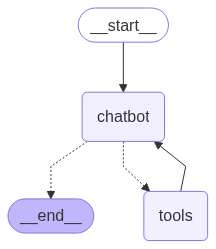

In [147]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass